## Bayesian Optimization with multiple objectives
Our pipeline should be as follows:
1. Define our design space as a grid or hyperplane etc
2. Define a model as surrogate to compute a score between target and a response query
3. Define acquistion function to score candidates
4. Define a selector to select candidate points
4. Define the optimization routine for the problem

In [1]:
import os
import torch
import time
import warnings
from botorch.exceptions import BadInitialCandidatesWarning

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [2]:
from botorch.test_functions.multi_objective import BraninCurrin
problem = BraninCurrin(negate=True).to(**tkwargs)
ref_point = problem.ref_point

In [3]:
# 1. design space
from head import Grid
import numpy as np

X = np.linspace(0,1, num=10) 
Y = np.linspace(0,1, num=10)
grid = Grid(X,Y)

def generate_initial_data(n=6):
    points = torch.from_numpy(grid.points)
    soboleng = torch.quasirandom.SobolEngine(dimension=1)
    train_xid = torch.floor(soboleng.draw(n)*len(grid)).to(**tkwargs)
    train_x = points[train_xid.long(),:]
    train_obj = problem(train_x)
    
    return torch.squeeze(train_x), torch.squeeze(train_obj)

train_x, train_obj = generate_initial_data(n=6)


In [4]:
# 2. define your model
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import pdb

def initialize_model(train_x, train_obj):
    # define models for objective and constraint
    model = SingleTaskGP(train_x, train_obj, 
                         outcome_transform=Standardize(m=train_obj.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_obj)

In [5]:
# 3. Define acqusition function
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler

partitioning = NondominatedPartitioning(ref_point=ref_point, Y=train_obj)
MC_SAMPLES = 128
qehvi_sampler = SobolQMCNormalSampler(num_samples=MC_SAMPLES)


acq_fun = lambda model: qExpectedHypervolumeImprovement(
    model=model,
    ref_point=ref_point.tolist(),  # use known reference point 
    partitioning=partitioning,
    sampler=qehvi_sampler,
)


In [6]:
# 4. define a optimization routine for acqusition function 
from botorch.optim.optimize import optimize_acqf_discrete
from botorch.utils.transforms import unnormalize

BATCH_SIZE = 4 
NUM_RESTARTS = 20 
RAW_SAMPLES = 1024

def selector(f):
    choices = torch.from_numpy(grid.points)
    new_x, _ = optimize_acqf_discrete(
        acq_function = f,
        q=BATCH_SIZE,
        choices = choices
    )
    new_obj = problem(new_x)
    return new_x, new_obj


In [7]:
# 5. define the opitmization loop

from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume

torch.manual_seed(0)


N_ITERATIONS = 25


verbose = False
hv = Hypervolume(ref_point=ref_point)

hvs_qehvi_all = []
hvs_qehvi = []

# compute pareto front
pareto_mask = is_non_dominated(train_obj)
pareto_y = train_obj[pareto_mask]
# compute hypervolume
volume = hv.compute(pareto_y)

hvs_qehvi.append(volume)

# run N_ITERATIONS rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ITERATIONS + 1):    
    
    # fit the models
    fit_gpytorch_model(mll)

    # define the acquisition modules using a QMC sampler
    acquisition = acq_fun(model)

    # optimize acquisition functions and get new observations
    new_x, new_obj = selector(acquisition)

    # update training points
    train_x= torch.cat([train_x, new_x])
    train_obj = torch.cat([train_obj, new_obj])

    # compute pareto front
    pareto_mask = is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    # compute hypervolume
    volume = hv.compute(pareto_y)
    hvs_qehvi.append(volume)

    # reinitialize the models so they are ready for fitting on next iteration
    # Note: we find improved performance from not warm starting the model hyperparameters
    # using the hyperparameters from the previous iteration
    mll_qehvi, model_qehvi = initialize_model(train_x, train_obj)

    print(".", end="")

    hvs_qehvi_all.append(hvs_qehvi)


.........................

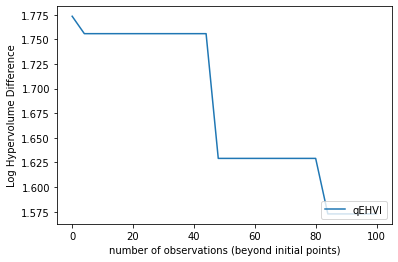

In [8]:
import numpy as np
from matplotlib import pyplot as plt


iters = np.arange(N_ITERATIONS + 1) * BATCH_SIZE
log_hv_difference_qehvi = np.log10(problem.max_hv - np.asarray(hvs_qehvi_all))

fig, ax = plt.subplots()

ax.plot(
    iters, log_hv_difference_qehvi.mean(axis=0),
    label="qEHVI", linewidth=1.5,
)

ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower right")

Text(0.5, 1.0, 'Iteration')

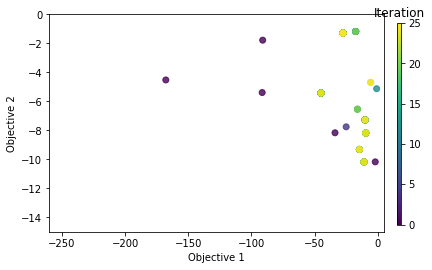

In [9]:
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 1)
cm = plt.cm.get_cmap('viridis')

batch_number = torch.cat(
    [torch.zeros(6), torch.arange(1, N_ITERATIONS+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]
).numpy()

sc = axes.scatter(train_obj[:, 0].cpu().numpy(), train_obj[:,1].cpu().numpy(), 
    c=batch_number, alpha=0.8,
)
axes.set_xlabel("Objective 1")
axes.set_xlim(-260, 5)
axes.set_ylim(-15, 0)
axes.set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")